Resources Used
- wget.download('https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py')
- Setup https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html

# 0. Setup Paths

In [6]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

# 1. Create Label Map

In [20]:
labels = [
    {'name':'Hello', 'id':1},
    {'name':'Yes', 'id':2},
    {'name':'No', 'id':3},
    {'name':'Thank You', 'id':4},
    {'name':'I Love You', 'id':5},
]

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 2. Create TF records

In [21]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record




W0401 21:53:31.011973  7356 module_wrapper.py:149] From h:\Project\RealTimeObjectDetection\Tensorflow\scripts\generate_tfrecord.py:153: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record




W0401 21:53:44.039230  8300 module_wrapper.py:149] From h:\Project\RealTimeObjectDetection\Tensorflow\scripts\generate_tfrecord.py:153: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



# 3. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [22]:
!cd Tensorflow && git clone https://github.com/tensorflow/models

Cloning into 'models'...
Updating files:  23% (929/3899)
Updating files:  24% (936/3899)
Updating files:  25% (975/3899)
Updating files:  26% (1014/3899)
Updating files:  27% (1053/3899)
Updating files:  28% (1092/3899)
Updating files:  29% (1131/3899)
Updating files:  30% (1170/3899)
Updating files:  31% (1209/3899)
Updating files:  32% (1248/3899)
Updating files:  33% (1287/3899)
Updating files:  34% (1326/3899)
Updating files:  35% (1365/3899)
Updating files:  36% (1404/3899)
Updating files:  37% (1443/3899)
Updating files:  38% (1482/3899)
Updating files:  38% (1501/3899)
Updating files:  39% (1521/3899)
Updating files:  40% (1560/3899)
Updating files:  41% (1599/3899)
Updating files:  42% (1638/3899)
Updating files:  43% (1677/3899)
Updating files:  44% (1716/3899)
Updating files:  44% (1748/3899)
Updating files:  45% (1755/3899)
Updating files:  46% (1794/3899)
Updating files:  47% (1833/3899)
Updating files:  48% (1872/3899)
Updating files:  49% (1911/3899)
Updating files:  50% 

In [6]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
#!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# 4. Copy Model Config to Training Folder

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

In [3]:
import os
import shutil

# Construct paths
model_dir = os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME)
src_config = os.path.join(PRETRAINED_MODEL_PATH, 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8', 'pipeline.config')
dst_config = os.path.join(MODEL_PATH, CUSTOM_MODEL_NAME, 'pipeline.config')

# Make directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Copy pipeline.config to the model directory
shutil.copy(src_config, dst_config)

'Tensorflow/workspace/models\\my_ssd_mobnet\\pipeline.config'

# 5. Update Config For Transfer Learning

In [8]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [4]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [6]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [7]:
config

{'model': ssd {
   num_classes: 5
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 4e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.01
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
    

In [8]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [9]:
pipeline_config.model.ssd.num_classes = 5 #edit this number based on number of classes in your dataset
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [10]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [11]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=10000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=10000


# 7. Load Train Model From Checkpoint

In [7]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [47]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 8. Detect in Real-Time

In [10]:
import cv2 
import numpy as np

In [48]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [52]:
cap.release()

In [50]:
# Setup capture
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

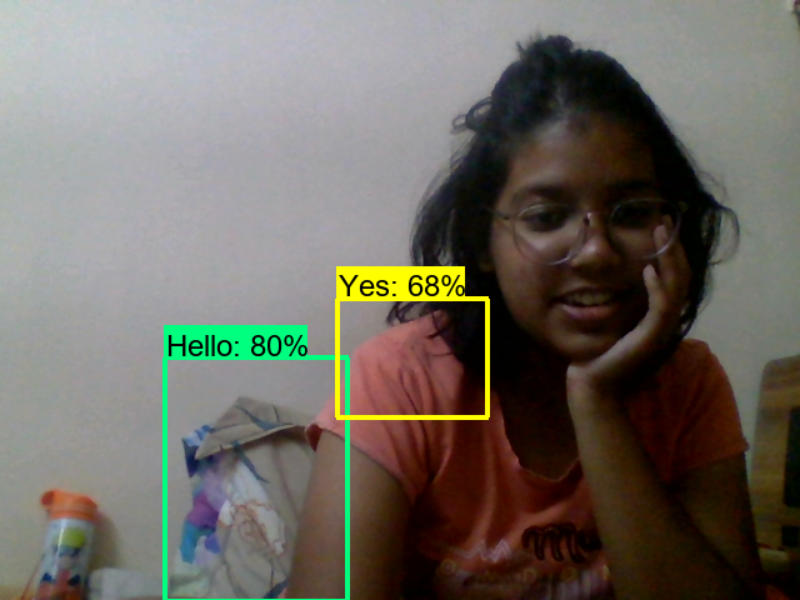

KeyboardInterrupt: 

In [51]:
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image
from IPython.display import display, clear_output
from object_detection.utils import visualization_utils as viz_utils

while True: 
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=5,
        min_score_thresh=.5,
        agnostic_mode=False)

    # Convert from BGR to RGB for display in Jupyter
    display_frame = cv2.cvtColor(cv2.resize(image_np_with_detections, (800, 600)), cv2.COLOR_BGR2RGB)
    
    clear_output(wait=True)
    display(Image.fromarray(display_frame))

    # Optional: break after one frame if you don’t want infinite loop
    # break

In [42]:
detections = detect_fn(input_tensor)

In [67]:
from matplotlib import pyplot as plt